# Genesis of Raphaël

Unleashing the power of DCNN to create random Raphaëls.

In [1]:
import json
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SpatialDropout2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import Dropout, Input, Dense, Flatten, Reshape, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model

from tqdm import tqdm

In [2]:
def build_generator(latent_size):    
    generator = Sequential([
        # (latent_size)
        Input(shape=(latent_size,), name="LatentNoise"),
        Dense(16*16*128, activation="relu"),
        # (16, 16, 384)
        Reshape((16, 16, 128)),
        # (32, 32, 192)
        UpSampling2D(),
        Conv2DTranspose(64, 3, padding="same", activation="relu"),
        Conv2DTranspose(64, 3, padding="same", activation="relu"),
        BatchNormalization(momentum=0.8),
        # (64, 64, 96)
        UpSampling2D(),
        Conv2DTranspose(32, 3, padding="same", activation="relu"),
        Conv2DTranspose(32, 3, padding="same", activation="relu"),
        BatchNormalization(momentum=0.8),
        # (128, 128, 3)
        UpSampling2D(),
        Conv2DTranspose(3, 3, padding="same", activation="sigmoid"),
        Conv2DTranspose(3, 3, padding="same", activation="sigmoid"),
    ], name="generator")
    
    return generator

def build_discriminator():
    
    discriminator = Sequential([
        # (128, 128, 3)
        Input(shape=(128, 128, 3), name="InputImages"),
        Conv2D(32, 3, padding="same", kernel_initializer="he_normal"),
        LeakyReLU(0.2),
        Conv2D(32, 3, padding="same", kernel_initializer="he_normal"),
        LeakyReLU(0.2),
        MaxPooling2D(),
        Dropout(0.2),
        
        Conv2D(64, 3, padding="same", kernel_initializer="he_normal"),
        LeakyReLU(0.2),
        Conv2D(64, 3, padding="same", kernel_initializer="he_normal"),
        LeakyReLU(0.2),
        MaxPooling2D(),
        Dropout(0.2),
        
        Conv2D(128, 3, padding="same", kernel_initializer="he_normal"),
        LeakyReLU(0.2),
        Conv2D(128, 3, padding="same", kernel_initializer="he_normal"),
        LeakyReLU(0.2),
        MaxPooling2D(),
        
        Flatten(),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(2, activation="softmax")        
    ], name="discriminator")
    
    return discriminator

In [3]:
generator = build_generator(100)

In [4]:
discriminator = build_discriminator()

In [5]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)      

In [6]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             3309568   
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 64)        0 

In [8]:
def build_combined(discriminator, generator, latent_size):
    noise = Input(shape=(latent_size, ), name="noise")
    fake_raph = generator(noise)
    discriminator.trainable = False
    validation = discriminator(fake_raph)
    return Model(noise, validation, name="combined")

In [9]:
combined = build_combined(discriminator, generator, 100)

In [10]:
combined.summary()

Model: "combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
generator (Sequential)       (None, 128, 128, 3)       3449335   
_________________________________________________________________
discriminator (Sequential)   (None, 2)                 4481698   
Total params: 7,931,033
Trainable params: 3,449,143
Non-trainable params: 4,481,890
_________________________________________________________________


In [11]:
opt = keras.optimizers.Adam(lr=0.0002, decay=1e-7)

discriminator.trainable = True
discriminator.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

combined.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [12]:
noise = np.random.normal(size=(1, 100))
rand_img = generator.predict(noise)

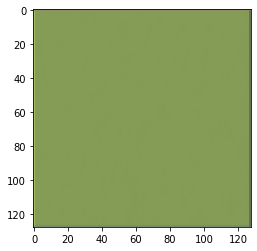

In [13]:
plt.imshow(rand_img.reshape((128, 128, 3)))

In [14]:
def batches_generator(data_path, batch_size):
    indexes = np.random.choice(len(data_path), len(data_path), replace=False)
    for batch_index in range(len(data_path) // batch_size):
        index = indexes[batch_index*batch_size:batch_index*batch_size + batch_size]
        batch = []
        labels = np.ones(batch_size)
        for i in index:
            batch.append(np.load(data_path[i]))
        yield np.array(batch), np.array(labels)

In [15]:
def see_the_raph_growing(generator, epoch=None, save_path=None, size=(4, 4), noise=None):
    if noise is None:
        noise = np.random.normal(size=(size[0]*size[1], 100))
    fake_imgs = generator.predict(noise)
    fig = plt.figure(figsize=(size[0]*4, size[1]*3))
    if not(epoch is None):
        fig.suptitle(f"Epoch {epoch}", size=20, y=0.92)
    for i, img in enumerate(fake_imgs):
        axes = fig.add_subplot(size[0], size[1], i+1)
        axes.set_axis_off()
        axes.imshow(img)
    if not(save_path is None):
        fig.savefig(save_path)
        plt.close(fig)

In [16]:
with open("../../data/processed_data.json", "r") as f:
    data_path = json.load(f)["path"]
epochs = 3000
batch_size = 30

validity = []
generation = []

size = len(data_path) - len(data_path) % batch_size 

with tqdm(total=size,
        unit='example') as pbar:
    
    gen = [0, 0]
    val = [0, 0]
    seed = np.random.normal(size=(16, 100))
    
    for e in tqdm(range(epochs), desc="Training", unit="epoch"):
        pbar.set_description(f"Epoch {e} - disc training")
        batch_gen = batches_generator(data_path, batch_size)
        
        discriminator.trainable = True
        
        for batch, labels in batch_gen:
            noise = np.random.normal(size=(batch_size, 100))
            fake_imgs = generator.predict(noise)
            fake_labels = np.zeros(batch_size)

            x = np.concatenate((np.array(batch), fake_imgs), axis=0)
            y = np.concatenate((np.array(labels), fake_labels))

            y = keras.utils.to_categorical(y)

            val = discriminator.train_on_batch(x, y)
            validity.append(val)
            
            pbar.update(len(batch))
            
        pbar.reset()
        pbar.set_description(f"Epoch {e} - gen training")
        
        batch_gen = batches_generator(data_path, batch_size)
        discriminator.trainable = False
        
        for batch, labels in batch_gen:
            noise = np.random.normal(size=(batch_size, 100))
            fake_imgs = generator.predict(noise)
            fake_labels = np.zeros(batch_size)

            x = np.concatenate((np.array(batch), fake_imgs), axis=0)
            y = np.concatenate((np.array(labels), fake_labels))

            y = keras.utils.to_categorical(y)
            
            gen = combined.train_on_batch(noise, y[batch_size-1:-1, :])
            generation.append(gen)
            
            pbar.update(len(batch))
            
        pbar.reset()
        
        if e % 100 == 0:
            see_the_raph_growing(generator, 
                                 epoch=e, 
                                 save_path=f"../../reports/generated_imgs/{e}.png",
                                 noise=seed)
        if e % 300 == 0:
            discriminator.save(f"../../models/discriminator-{e}.h5")
            combined.save(f"../../models/combined-{e}.h5")
            generator.save(f"../../models/generator-{e}.h5")
    
    with open(f"../../reports/metrics/generation.json", "w+") as f:
        json.dump(generation, f)
    with open(f"../../reports/metrics/validity.json", "w+") as f:
        json.dump(validity, f)

Epoch 0 - disc training:  10%|█         | 30/300 [00:04<00:39,  6.79example/s]


KeyboardInterrupt: 

In [ ]:
see_the_raph_growing(generator)

In [ ]:
discriminator.save("../../models/discriminator.h5")
combined.save("../../models/combined.h5")
generator.save("../../models/generator.h5")

In [ ]:
generation = np.array(generation)
validity = np.array(validity)

gen_acc = generation[:,1]
disc_acc = validity[:,1]

fig = plt.figure()
fig.suptitle("Training history", size=20, y=0.92)
ax = fig.add_axes([0.9, 0.9, 0.9, 0.9])
gen_line = ax.plot(np.arange(len(gen_acc)), gen_acc)
disc_line = ax.plot(np.arange(len(disc_acc)), disc_acc)
fig.legend((gen_line, disc_line), ("Generative", "Discriminative"), title="Accuracy")